# Detecção de Veículos com YOLOv5 Adaptado
### Projeto PBL – Fase 6 | Entrega 1 – FarmTech Solutions

Este notebook apresenta o desenvolvimento de um sistema de visão computacional com YOLOv5 para detecção de veículos (Carro e Moto).  
O objetivo é demonstrar a eficácia da detecção e avaliar o impacto do número de épocas no desempenho do modelo.

O processo inclui:
- Preparação e rotulagem de um dataset customizado
- Treinamento do modelo com 30 e 60 épocas
- Comparação de métricas de desempenho
- Visualização dos resultados de inferência


## Introdução - PBL Fase 6 – Visão Computacional com YOLOv5

## Preparação

### Imports Iniciais

Nesta célula, são realizados os imports essenciais para execução do notebook, incluindo:

- Bibliotecas de sistema (`os`, `subprocess`, `glob`, `time`)
- Bibliotecas para verificação de hardware e uso de GPU (`torch`)
- Bibliotecas de visualização para análise dos resultados (`matplotlib`)


In [1]:
import os
import torch
import subprocess
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import pandas as pd
from IPython.display import FileLink

### Verificação do Ambiente e da GPU

Antes de iniciar o treinamento do modelo YOLOv5, é importante verificar se o ambiente está utilizando uma GPU. O uso de GPU é altamente recomendado, especialmente no Google Colab, pois acelera significativamente o processo de treinamento e evita possíveis interrupções por tempo limite.

> 💡 Este notebook pode ser executado tanto no **Google Colab** quanto **localmente**. A verificação abaixo ajuda a garantir que os recursos computacionais estão adequados antes de seguir.

In [2]:
# Função auxiliar para detectar se está no Colab
def esta_no_colab():
    return 'COLAB_GPU' in os.environ

# Verificação do ambiente
if esta_no_colab():
    print("🟢 Ambiente detectado: Google Colab")
else:
    print("💻 Ambiente detectado: Execução Local")

# Verificação de GPU
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    print(f"\033[92m✅ GPU disponível:\033[0m {device_name}")
    print("O ambiente está configurado corretamente para o treinamento.")
else:
    print("\033[91m❌ ATENÇÃO: GPU não disponível. O notebook está executando em CPU.\033[0m\n")
    print("❗ O treinamento com YOLOv5 em CPU pode ser extremamente lento e sujeito a interrupções por tempo limite.\n")
    
    if esta_no_colab():
        print("\033[1mRecomendações para ativar GPU no Colab:\033[0m")
        print("- Vá até o menu 'Ambiente de execução > Alterar tipo de ambiente de execução'")
        print("- Selecione 'GPU' como acelerador de hardware e clique em 'Salvar'")
        print("- O ambiente será reiniciado. Após a reinicialização, reexecute esta célula antes de continuar.")


💻 Ambiente detectado: Execução Local
✅ GPU disponível: NVIDIA GeForce RTX 3060 Laptop GPU
O ambiente está configurado corretamente para o treinamento.


### Conexão com o Google Drive ou Ambiente Local

Nesta etapa, o notebook verifica automaticamente se está sendo executado no Google Colab ou em ambiente local. Em seguida, realiza a montagem do Google Drive (caso Colab) e define os caminhos apropriados para acessar o dataset e o arquivo de configuração `.yaml` do YOLOv5.

Isso garante que o notebook funcione de forma flexível, independentemente do ambiente de execução.

In [3]:
try:
    from google.colab import drive
    print("✅ Executando no Google Colab")

    # Monta o Google Drive se necessário
    drive_path = "/content/drive"
    mydrive_path = os.path.join(drive_path, "MyDrive")
    if not os.path.exists(mydrive_path):
        print("🔄 Google Drive não está montado. Montando agora...")
        drive.mount(drive_path)
    else:
        drive.mount(drive_path, force_remount=True)
        print("✅ Google Drive já está montado.")

    # Caminho no Google Drive
    dataset_dir = os.path.join(mydrive_path, "1TIAOR20242_FASE6_CAP1")
    yaml_filename = "veiculos.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

except ImportError:
    print("✅ Executando localmente")

    # Caminho local padrão
    dataset_dir = os.path.abspath("../")
    yaml_filename = "veiculos_local.yaml"
    pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

    # Se não encontrar, tenta um nível acima
    if not os.path.exists(pathConfiguration):
        dataset_dir = os.path.abspath("../../")
        pathConfiguration = os.path.join(dataset_dir, "configuration", yaml_filename)

# Validação final
if not os.path.exists(pathConfiguration):
    raise FileNotFoundError(f"Arquivo não encontrado: {pathConfiguration}")

# Exibe os caminhos definidos
print(f"Caminho dos Datasets: {dataset_dir}")
print(f"Arquivo de configuração: {pathConfiguration}")


✅ Executando localmente
Caminho dos Datasets: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1
Arquivo de configuração: /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/configuration/veiculos_local.yaml


### Clonagem do Repositório e Instalação das Dependências do YOLOv5

A seguir, será feito o clone do repositório oficial do [YOLOv5](https://github.com/ultralytics/yolov5), desenvolvido pela Ultralytics. Esse repositório contém todos os scripts e configurações necessários para treinar, validar e executar modelos de detecção de objetos com YOLOv5.

Após clonar o repositório YOLOv5, será instalado as bibliotecas listadas no arquivo `requirements.txt`.  Essa instalação será executada de forma programática e silenciosa, facilitando o uso tanto no Google Colab quanto em ambiente local.

> A clonagem é necessária apenas uma vez por ambiente. Caso esteja executando localmente e já tenha o repositório clonado, esta etapa vai ser ignorada.


In [4]:
def install_dependencies():
    try:
        # Executa o comando de instalação e suprime a saída
        result = subprocess.run(
            ["pip", "install", "-r", "yolov5/requirements.txt"],
            stdout=subprocess.PIPE,  # Suprime a saída padrão
            stderr=subprocess.PIPE,  # Suprime a saída de erro
            text=True,
            check=True  # Levanta uma exceção se o comando falhar
        )
        print("✅ Instalação concluída com sucesso!")
    except subprocess.CalledProcessError as e:
        print("❌ Erro durante a instalação.")
        print(f"Detalhes do erro: {e.stderr}")


# Verificar se o YOLOv5 já está instalado
if os.path.exists("yolov5"):
    print("✅ YOLOv5 já está instalado.")
else:
    #Clonar o repositório oficial do YOLOv5
    !git clone https://github.com/ultralytics/yolov5
    
    # Chama a função para instalar as dependências
    install_dependencies()

✅ YOLOv5 já está instalado.


## Treinamentos dos Modelos com 30 e 60 Épocas (YOLOv5 Adaptado)

Nesta etapa, serão realizados dois treinamentos com o modelo YOLOv5 adaptado, utilizando os mesmos dados e configurações, mas variando o número de épocas para fins comparativos.

Ambos os modelos foram treinados com os seguintes parâmetros:

- `--img 640`: redimensiona as imagens para 640x640 pixels
- `--batch 16`: define o tamanho do lote (batch size)
- `--weights yolov5s.pt`: modelo pré-treinado base (YOLOv5 Small)
- `--data`: arquivo `.yaml` com as classes e caminhos para os datasets
- `--name`: define o nome do experimento e pasta de saída
- `--epochs`: 30 ou 60, dependendo da simulação

Os treinamentos foram realizados de forma assíncrona via `subprocess`, com saída registrada em arquivos `.log`, permitindo melhor controle de execução e acompanhamento do tempo total.

### Treinamento do Modelo com 30 Épocas

Execução do treinamento inicial com 30 épocas, registrando métricas e tempo total para posterior comparação com o modelo de 60 épocas.


In [5]:
# Função para executar o comando e monitorar o processo
def executar_treinamento(command, nome_treinamento, log_file_path):
    # Marca o tempo de início do treinamento
    inicio = time.time()
    # Cria o diretório de logs se não existir
    os.makedirs(os.path.dirname(log_file_path), exist_ok=True)
    
    # Verifica se o arquivo de log já existe
    if os.path.exists(log_file_path):
        print(f"⚠️ O arquivo de log {log_file_path} já existe. Ele será sobrescrito.")
    else:
        print(f"✅ Criando o arquivo de log {log_file_path}.")
    
    # Abre o arquivo de log para escrita
    with open(log_file_path, "w") as log_file:
        try:
            # Inicia o processo
            process = subprocess.Popen(
                command,
                stdout=log_file,  # Redireciona stdout para o arquivo de log
                stderr=log_file,  # Redireciona stderr para o arquivo de log
                text=True
            )

            print(f"Treinamento {nome_treinamento} iniciado. Acompanhe o progresso no arquivo de log.")

            # Verifica se o processo ainda está em execução
            pontos = ""  # String para acumular os pontos
            while process.poll() is None:
                pontos += "."  # Adiciona um ponto a cada iteração
                print(f"Treinamento em andamento{pontos}", end="\r")  # Atualiza na mesma linha
                time.sleep(10)  # Aguarda 10 segundos antes de verificar novamente

            # Verifica o código de saída
            if process.returncode == 0:
                print(f"Treinamento {nome_treinamento} concluído com sucesso!")
            else:
                print(f"Erro durante o treinamento {nome_treinamento}. Verifique o log: {log_file_path}")
        except Exception as e:
            print(f"Erro ao executar o comando: {e}")
    
    # Marca o tempo de término e calcula a duração
    fim = time.time()

    # Calcula a duração do treinamento
    duracao = fim - inicio
    # Exibe a duração do treinamento
    print(f"Tempo de treinamento {nome_treinamento}: {duracao:.2f} segundos")

In [6]:
# Caminho do arquivo de log
nome_treinamento_30ep = "veiculos_yolo_30ep"

# Caminho do arquivo de log
log_file_path = f'./logs/{nome_treinamento_30ep}.log'

# Parâmetros utilizados:
# --img: define o tamanho das imagens de entrada (640x640 pixels)
# --batch: número de imagens processadas por vez (tamanho do lote)
# --epochs: número total de épocas de treinamento
# --data: caminho do arquivo .yaml com o dataset e classes
# --weights: modelo base pré-treinado (YOLOv5s)
# --name: nome da pasta onde os resultados serão salvos
# --exist-ok: permite sobrescrever a pasta de saída se ela já existir

# Comando de treinamento
command = [
    "python", "./yolov5/train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "30",
    "--data", pathConfiguration,
    "--weights", "yolov5s.pt",
    "--name", f"{nome_treinamento_30ep}",
    "--exist-ok"
]

# Executa o treinamento
executar_treinamento(command, nome_treinamento_30ep, log_file_path)

⚠️ O arquivo de log ./logs/veiculos_yolo_30ep.log já existe. Ele será sobrescrito.
Treinamento veiculos_yolo_30ep iniciado. Acompanhe o progresso no arquivo de log.
Treinamento veiculos_yolo_30ep concluído com sucesso!
Tempo de treinamento veiculos_yolo_30ep: 75.07 segundos


### Treinamento do Modelo com 60 Épocas

Execução do segundo treinamento, agora com 60 épocas, mantendo os mesmos parâmetros e estrutura do modelo anterior.

In [7]:
# Caminho do arquivo de log
nome_treinamento_60ep = "veiculos_yolo_60ep"

# Caminho do arquivo de log
log_file_path = f'./logs/{nome_treinamento_60ep}.log'

# Parâmetros utilizados:
# --img: define o tamanho das imagens de entrada (640x640 pixels)
# --batch: número de imagens processadas por vez (tamanho do lote)
# --epochs: número total de épocas de treinamento
# --data: caminho do arquivo .yaml com o dataset e classes
# --weights: modelo base pré-treinado (YOLOv5s)
# --name: nome da pasta onde os resultados serão salvos
# --exist-ok: permite sobrescrever a pasta de saída se ela já existir

# Comando de treinamento
command = [
    "python", "./yolov5/train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "60",
    "--data", pathConfiguration,
    "--weights", "yolov5s.pt",
    "--name", f"{nome_treinamento_60ep}",
    "--exist-ok"
]

# Executa o treinamento
executar_treinamento(command, nome_treinamento_60ep, log_file_path)

⚠️ O arquivo de log ./logs/veiculos_yolo_60ep.log já existe. Ele será sobrescrito.
Treinamento veiculos_yolo_60ep iniciado. Acompanhe o progresso no arquivo de log.
Treinamento veiculos_yolo_60ep concluído com sucesso!
Tempo de treinamento veiculos_yolo_60ep: 110.12 segundos


## Análise dos Resultados de Treinamento


### Gráficos Automáticos Gerados pelo YOLOv5

Os gráficos abaixo foram gerados automaticamente pelo YOLOv5 ao final de cada treinamento. Eles mostram a evolução das métricas de perda e desempenho por época para os modelos treinados com 30 e 60 épocas.

Cada conjunto de gráficos inclui:
- Perdas no treinamento e validação (`box_loss`, `obj_loss`, `cls_loss`)
- Métricas de avaliação (`precision`, `recall`, `mAP@0.5`, `mAP@0.5:0.95`)


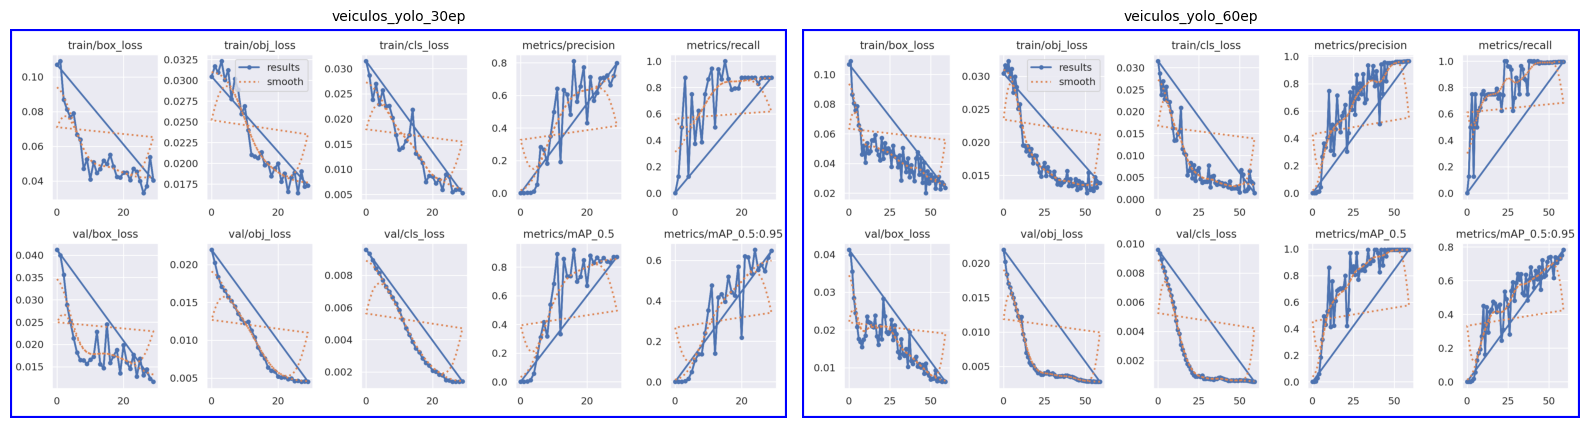

In [8]:
# Lista os arquivos resultantes da inferência (JPG ou JPEG)
resultado_imgs = glob.glob(f'./yolov5/runs/train/{nome_treinamento_30ep}/results.png') + glob.glob(f'./yolov5/runs/train/{nome_treinamento_60ep}/results.png') 

# Seleciona as 2 imagens
imagens_selecionadas = resultado_imgs[:2]

# Configura o layout do grid (1x2)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Itera sobre as imagens e os eixos para exibir
for i, ax in enumerate(axes.flat):
    if i < len(imagens_selecionadas):
        img = mpimg.imread(imagens_selecionadas[i])
        ax.imshow(img)
        ax.set_title(imagens_selecionadas[i].split('/')[-2], fontsize=10)  # Nome da pasta de treino
        ax.axis('off')
        rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=3, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


### Comparação Direta Entre Modelos (Resultados CSV)

A seguir, apresentamos gráficos comparativos gerados a partir dos arquivos `results.csv`. Essa visualização permite comparar diretamente, métrica a métrica, o desempenho dos modelos com 30 e 60 épocas ao longo do tempo.

As métricas analisadas incluem:
- `train/box_loss`: perda da caixa no treino
- `train/obj_loss`: perda de objetos no treino
- `metrics/precision`: precisão na validação
- `metrics/recall`: recall na validação
- `metrics/mAP_0.5`: média de precisão com IoU ≥ 0.5


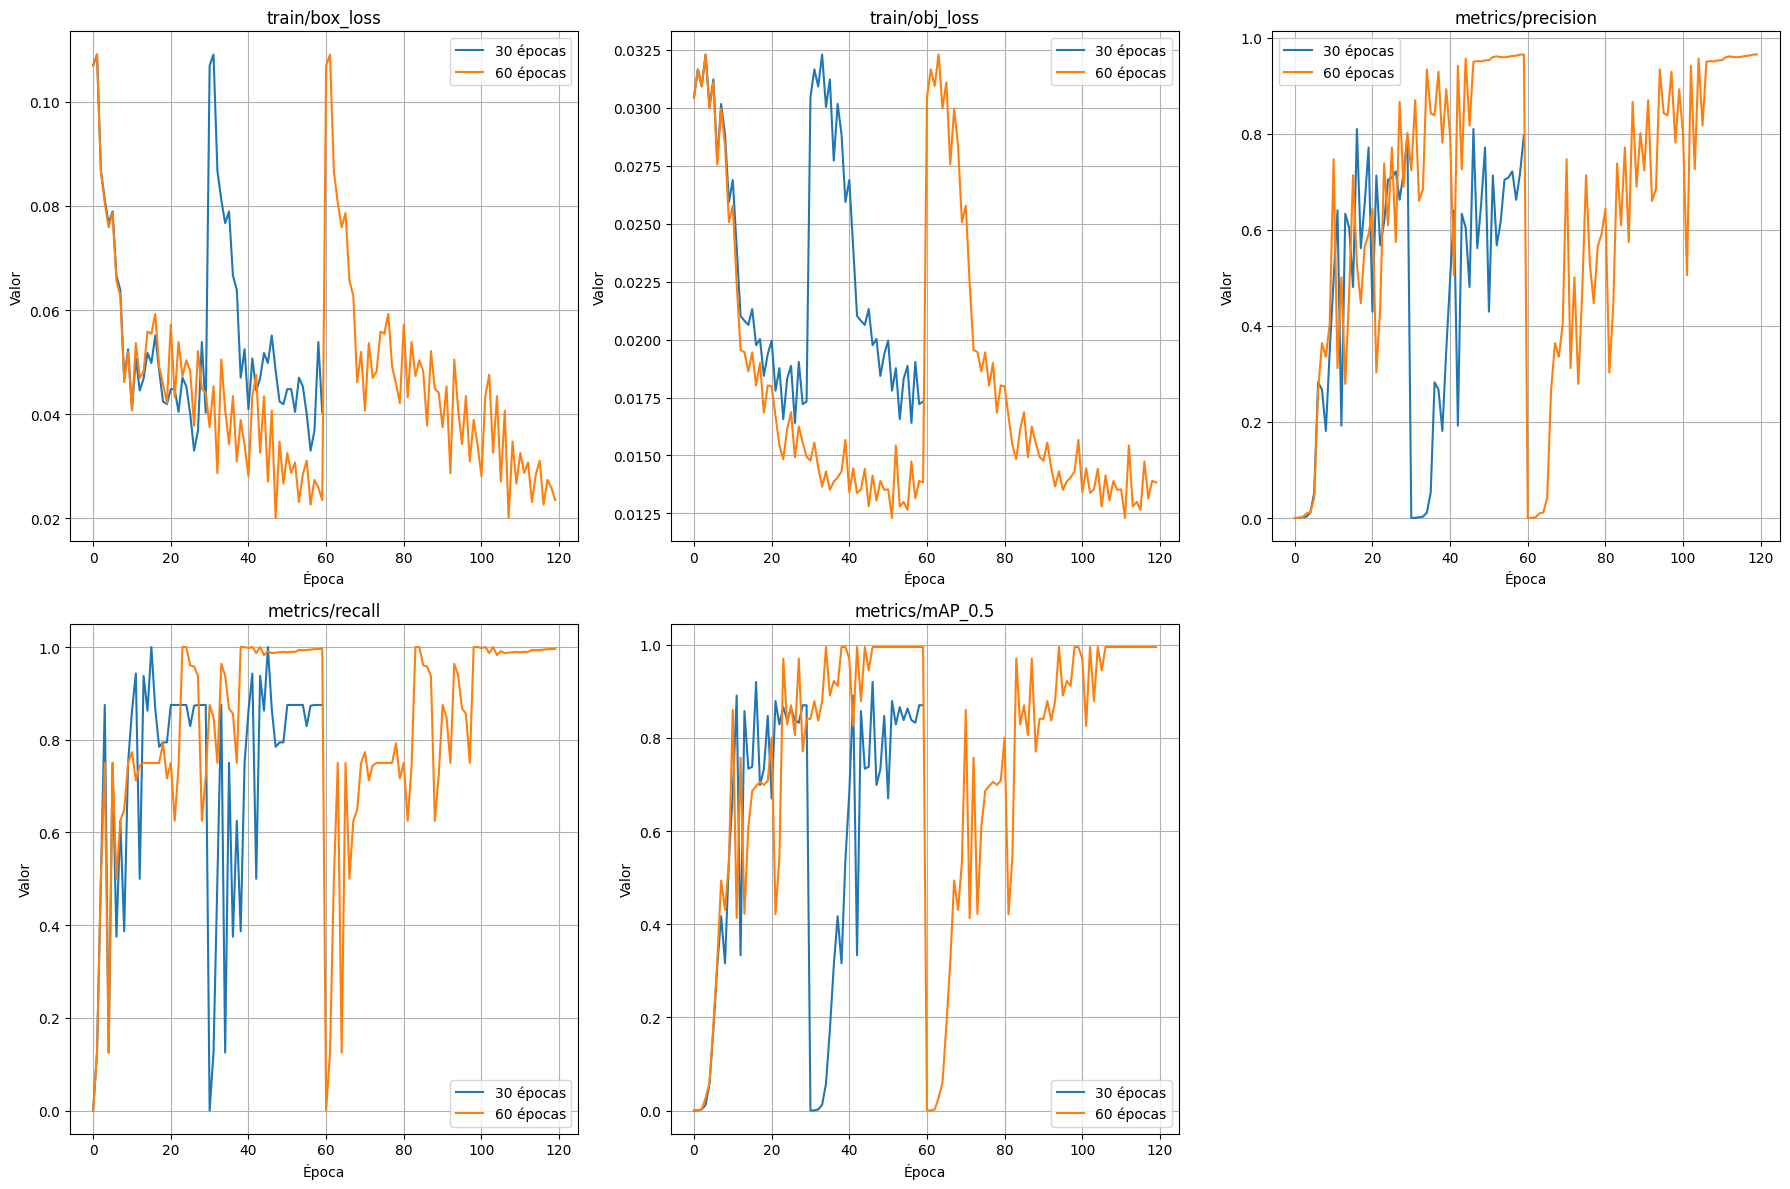

In [9]:
# Leitura dos CSVs
df_30 = pd.read_csv(f'yolov5/runs/train/{nome_treinamento_30ep}/results.csv')
df_60 = pd.read_csv(f'yolov5/runs/train/{nome_treinamento_60ep}/results.csv')

# Corrige os nomes das colunas
df_30.columns = df_30.columns.str.strip()
df_60.columns = df_60.columns.str.strip()

# Define as métricas a comparar
metricas = ['train/box_loss', 'train/obj_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5']

# Gera os gráficos comparativos
plt.figure(figsize=(18, 12))

for i, metrica in enumerate(metricas):
    plt.subplot(2, 3, i+1)
    plt.plot(df_30[metrica], label='30 épocas')
    plt.plot(df_60[metrica], label='60 épocas')
    plt.title(metrica)
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


### Análise Comparativa entre os Treinamentos (30 vs 60 Épocas)

Com base nos gráficos gerados automaticamente pelo YOLOv5 (`results.png`) e nos gráficos personalizados a partir do `results.csv`, é possível observar as seguintes tendências e insights:

#### 🔹 Perdas de Treinamento (`box_loss` e `obj_loss`)
- Ambas as curvas mostram uma redução consistente ao longo das épocas.
- O modelo com **60 épocas** apresenta uma curva mais estável e suave, com valores finais ligeiramente menores — o que indica um ajuste mais fino dos pesos da rede.

#### 🔹 Precisão e Recall
- Os dois modelos alcançam altos níveis de **precisão** e **recall**, próximos a 1.0.
- O modelo com **30 épocas** apresentou mais oscilações nas métricas, enquanto o modelo de **60 épocas** manteve um crescimento mais contínuo, atingindo valores mais estáveis nas últimas épocas.

#### 🔹 mAP@0.5 (Mean Average Precision)
- O modelo com **60 épocas** obteve um `mAP@0.5` ligeiramente superior ao de 30 épocas, demonstrando uma melhor capacidade de generalização para o conjunto de validação.
- A diferença, no entanto, não é extremamente grande — sugerindo que o modelo com 30 épocas já entrega resultados satisfatórios com menos tempo de treino (~72s vs ~120s).

---

#### 🎯 Conclusão Parcial
O aumento para 60 épocas trouxe melhorias em todas as métricas avaliadas, mas com **ganhos marginais** em relação ao tempo adicional de execução. Essa análise reforça a importância de considerar não apenas a performance, mas também o **custo computacional** ao ajustar hiperparâmetros como o número de épocas.

A próxima etapa será aplicar os dois modelos no conjunto de teste e avaliar, na prática, como essas diferenças se traduzem na **capacidade de detecção visual dos objetos**.


## Inferência no Conjunto de Teste

Após o treinamento dos modelos YOLOv5 com 30 e 60 épocas, agora aplicamos cada modelo sobre o conjunto de imagens de teste.

O objetivo é observar visualmente como os modelos se comportam na detecção dos objetos `Carro` e `Moto`, avaliando:
- Precisão da detecção
- Quantidade de falsos positivos ou negativos
- Diferença entre os modelos com base no número de épocas

As inferências serão realizadas usando o script `detect.py` do YOLOv5.


In [10]:
# Caminho das imagens de teste
imagens_teste = os.path.join(dataset_dir, "dataset_images", "images", "test")

# Caminho para os pesos treinados
pesos_30ep = f'yolov5/runs/train/{nome_treinamento_30ep}/weights/best.pt'

# Comando de inferência
!python yolov5/detect.py --weights {pesos_30ep} --img 640 --conf 0.25 --source {imagens_teste} --name {nome_treinamento_30ep}_test --exist-ok


detect: weights=['yolov5/runs/train/veiculos_yolo_30ep/weights/best.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=veiculos_yolo_30ep_test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 2 Carros, 38.6ms
image 2/8 /home/joseandre/fiap_projetos/1TIA

In [11]:
# Caminho para os pesos treinados
pesos_60ep = f'yolov5/runs/train/{nome_treinamento_60ep}/weights/best.pt'

# Comando de inferência
!python yolov5/detect.py --weights {pesos_60ep} --img 640 --conf 0.25 --source {imagens_teste} --name {nome_treinamento_60ep}_test --exist-ok


detect: weights=['yolov5/runs/train/veiculos_yolo_60ep/weights/best.pt'], source=/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=veiculos_yolo_60ep_test, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/8 /home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/dataset_images/images/test/Imagem073.jpg: 480x640 1 Carro, 43.4ms
image 2/8 /home/joseandre/fiap_projetos/1TIAO

### Visualização das Inferências

A seguir, são exibidas as inferências realizadas com os modelos treinados por 30 e 60 épocas. As imagens geradas demonstram a detecção de `Carro` e `Moto` em diferentes situações do conjunto de teste.

A comparação visual ajuda a identificar:
- Diferenças na confiança das detecções
- Casos em que o modelo detecta corretamente (ou não)
- Possíveis falsos positivos ou negativos


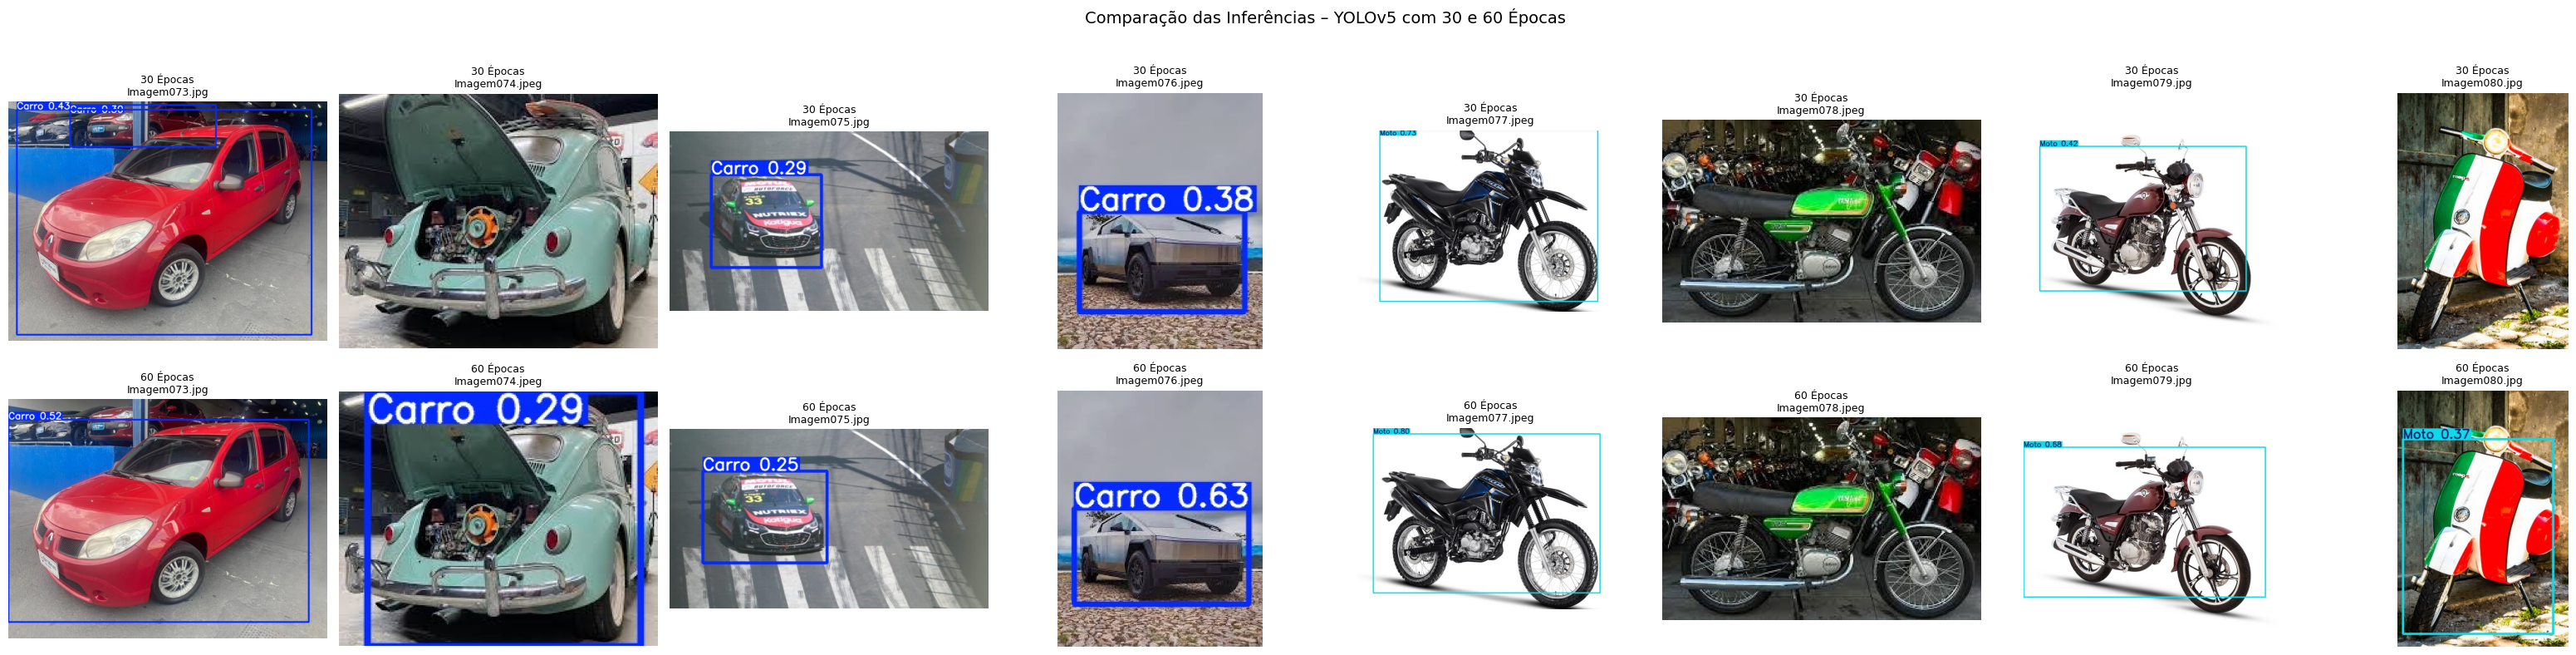

In [12]:
# Diretórios de saída
dir_30 = f'yolov5/runs/detect/{nome_treinamento_30ep}_test'
dir_60 = f'yolov5/runs/detect/{nome_treinamento_60ep}_test'

def get_images(folder, n=8):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp')
    imgs = []
    for e in exts:
        imgs += glob.glob(os.path.join(folder, e))
    return sorted(imgs)[:n]

# Lista de imagens detectadas (as mesmas usadas nos testes)
imgs_30 = get_images(dir_30)
imgs_60 = get_images(dir_60)

# Número máximo de imagens
num_imgs = min(8, len(imgs_30), len(imgs_60))

fig, axes = plt.subplots(2, num_imgs, figsize=(num_imgs * 4, 8))

for i in range(num_imgs):
    # Linha 0 = 30 épocas
    img30 = mpimg.imread(imgs_30[i])
    axes[0, i].imshow(img30)
    axes[0, i].set_title(f'30 Épocas\n{os.path.basename(imgs_30[i])}', fontsize=9)
    axes[0, i].axis('off')

    # Linha 1 = 60 épocas
    img60 = mpimg.imread(imgs_60[i])
    axes[1, i].imshow(img60)
    axes[1, i].set_title(f'60 Épocas\n{os.path.basename(imgs_60[i])}', fontsize=9)
    axes[1, i].axis('off')

plt.suptitle("Comparação das Inferências – YOLOv5 com 30 e 60 Épocas", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # espaço para o título
plt.show()



### Comparação Visual – Detecções com 30 e 60 Épocas

A imagem acima compara os resultados de inferência entre os modelos treinados com 30 e 60 épocas para as mesmas imagens de teste.

Cada **coluna** representa uma imagem de teste, com a versão do modelo de 30 épocas no topo e a de 60 épocas abaixo. Essa disposição facilita uma análise direta de:

- Diferenças no nível de confiança das detecções
- Consistência entre os modelos
- Possíveis erros ou acertos específicos

O modelo com 60 épocas demonstrou melhor estabilidade, maior confiança e sensibilidade a objetos parcialmente visíveis em alguns casos.


## Conclusão Final – Entrega 1

Nesta entrega, foi desenvolvido um sistema de visão computacional utilizando o modelo YOLOv5 adaptado para detecção de dois objetos: `Carro` e `Moto`. O projeto foi preparado para execução tanto em ambiente Google Colab quanto localmente, com flexibilidade total na estrutura e nos caminhos.


### Principais Etapas Concluídas:
- Montagem e organização de um dataset rotulado manualmente com MakeSense.ai
- Treinamento do modelo YOLOv5 com 30 e 60 épocas
- Armazenamento e comparação das métricas de desempenho e tempos de execução
- Análise visual das inferências realizadas sobre o conjunto de teste

### Resultados Observados:
- O modelo com 60 épocas apresentou uma leve melhora nas métricas (`precision`, `recall`, `mAP`) e maior estabilidade nas curvas de treinamento.
- O modelo com 30 épocas, apesar do menor tempo de execução, já mostrou desempenho satisfatório, especialmente para contextos com menor capacidade computacional.
- Visualmente, o modelo com 60 épocas teve uma leve vantagem em detecções mais sutis e consistentes.

### Principais Aprendizados
- ✅ O YOLOv5 adaptado apresentou ótimo desempenho mesmo com datasets pequenos
- ⏱️ Aumentar o número de épocas melhora o desempenho, mas com custo computacional
- 🔍 A visualização das inferências é crucial para validar a generalização do modelo
- 📊 A análise combinada de métricas, gráficos e inferências revela o comportamento real do modelo
- 🔄 Flexibilidade entre Google Colab e execução local é essencial em projetos de visão computacional
- 📈 O tempo de execução deve ser avaliado em conjunto com a performance final
- 🛠️ Ferramentas como MakeSense.ai agilizam e estruturam a rotulagem de forma prática
- 📉 A comparação visual permite identificar diferenças sutis entre versões do modelo
- 🔄 Executar treinamentos de forma assíncrona melhora o controle e o monitoramento
- 🧠 A escolha dos parâmetros (épocas, batch size, etc.) deve sempre considerar o cenário de aplicação


### Considerações Finais:
A entrega demonstrou com sucesso o uso prático do YOLOv5 em um cenário realista de detecção de objetos, além de ressaltar a importância de decisões relacionadas a custo computacional e desempenho.

A próxima etapa do projeto será a comparação com outras abordagens: a YOLO tradicional e uma CNN desenvolvida do zero.

#### 📄 Acesso ao Log de Treinamento (30 Épocas)

Clique abaixo para visualizar o log completo do treinamento com 30 épocas. O arquivo contém a saída detalhada do processo, incluindo perda por época e tempo de execução.

In [13]:
FileLink('./logs/veiculos_yolo_30ep.log')

/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/notebooks/logs/veiculos_yolo_30ep.log

#### 📄 Acesso ao Log de Treinamento (60 Épocas)
Clique abaixo para visualizar o log completo do treinamento com 60 épocas. O arquivo contém a saída detalhada do processo, incluindo perda por época e tempo de execução.

In [14]:
FileLink('./logs/veiculos_yolo_60ep.log')

/home/joseandre/fiap_projetos/1TIAOR20242_FASE6_CAP1/notebooks/logs/veiculos_yolo_60ep.log